## 第一步，导入必要的包

我们用到的主要分为三大类：
数据导入及处理、特征工程及挖掘、可视化

In [31]:
#载入必要的包
import pandas as pd
import numpy as np
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
import warnings
# 忽略不必要的warnings
warnings.filterwarnings('ignore')

# 作图
%matplotlib inline
sns.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2.5)


## 第二步，数据录入


In [32]:
#数据
df=pd.read_csv('lesson1.csv',encoding='gbk')
df.head()

,class0,price,rank1_list,stars,reviews,delivery,rank_big,brand,stock
0,x1,180.00,1,4.4,6442,Sold by Furbo and Fulfilled by Amazon.,287.0,Furbo,In Stock.
1,x1,32.99,2,3.9,1839,Sold by Trekking tribe and Fulfilled by Amazon.,1310.0,TOOGE,In Stock.
2,x1,29.99,3,4.2,2032,Sold by FORamerica and Fulfilled by Amazon.,0.0,BOOCOSA-US,In Stock.
3,x1,139.95,4,4.4,376,Sold by Petkey and Fulfilled by Amazon.,8004.0,WOPET,In Stock.
4,x1,29.99,5,3.8,322,Sold by VI-SON and Fulfilled by Amazon.,9203.0,VINSION,In Stock.


In [33]:
# 数值化数据的描述
df.describe()

,price,rank1_list,stars,reviews,rank_big
count,546.000000,546.000000,546.00000,546.000000,5.460000e+02
mean,37.554332,25.410256,4.03370,301.384615,3.950600e+09
std,48.625505,14.361780,1.04309,693.007210,6.544901e+10
min,0.000000,1.000000,0.00000,0.000000,0.000000e+00
25%,10.950000,13.000000,3.90000,14.250000,4.410000e+03
50%,18.980000,25.000000,4.30000,65.500000,1.551550e+04
75%,42.252500,38.000000,4.60000,234.250000,6.761225e+04
max,389.000000,50.000000,5.00000,6442.000000,1.170000e+12


In [36]:
# 空缺值判断，其中，价格、排名是我们重点关注的
df.loc[df['price']==0,'price']=None
df.loc[df['rank_big']==0,'rank_big']=None

df.isnull().any()

class0        False
price         False
rank1_list    False
stars         False
reviews       False
delivery       True
rank_big       True
brand         False
stock         False
dtype: bool

## 第三步，数据预处理

这节课主要是讲我们拿到数据后怎么处理
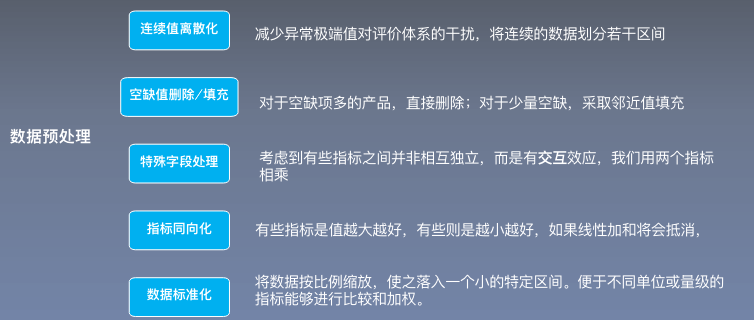

### 删除空缺字段多的产品
在这里主要是针对价格price，品牌brand以及库存in_stock三个字段中是否都缺作为依据

`DataFrame.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)`，

```
axis:维度，axis=0表示index行,axis=1表示columns列，默认为0
how:"all"表示这一行或列中的元素全部缺失（为nan）才删除这一行或列，"any"表示这一行或列中只要有元素缺失，就删除这一行或列
thresh:一行或一列中至少出现了thresh个才删除。
subset：在某些列的子集中选择出现了缺失值的列删除，不在子集中的含有缺失值得列或行不会删除（有axis决定是行还是列）
inplace：刷选过缺失值得新数据是存为副本还是直接在原数据上进行修改。

```

In [38]:
# 缺货的删掉
df=df[df['stock']!='Currently unavailable.']
# 删除空缺的
df=df.dropna(axis=0, how='any', subset=['brand','price','stock'], inplace=False)

In [39]:
# 各个类别，筛选出至少有30（80%）个以上商品的小类，过少的没意义
p1=df['class0'].value_counts()
p1

x9     50
x2     50
x7     49
x1     49
x5     47
x10    47
x4     46
x3     45
x8     41
x6     37
x11    34
Name: class0, dtype: int64

In [40]:
p2=list(p1[df['class0'].value_counts()>40].index)
print(p2)
#剔除掉不足40个的，需要重新抓之类的
df_clean=df[df['class0'].isin(p2)]
df_clean['class0'].value_counts()

['x9', 'x2', 'x7', 'x1', 'x5', 'x10', 'x4', 'x3', 'x8']


x9     50
x2     50
x7     49
x1     49
x5     47
x10    47
x4     46
x3     45
x8     41
Name: class0, dtype: int64

### 空缺值填补

针对排名有缺失的，我们用*临近值*来进行填充，在pandas中，会用到`DataFrame.fillna(method='backfill')`函数，，其中`method`可以是`backfill`-空缺值后面的值替换缺失值；`pad`-空缺值前面的值替换缺失值；直接赋值`fillna(0)`，用0来填补 

在实际情况中，可能需要我们用更符合实际情况的填充方式，之后的课程中会涉及


In [41]:
#其中，大类排名用前后值来
df['rank_big_up']=df['rank_big']
df['rank_big_down']=df['rank_big']
df['rank_big']=(df['rank_big_up'].fillna(method='pad')+df['rank_big_down'].fillna(method='backfill'))/2

#对delivery的填补
df['delivery']=df['delivery'].fillna('none')

### 连续数值变量离散化
包括：
- 小类排名：小于10，大于10
- reviews评论：按照50,100,300,1000,1500,2000和大于2000
- 价格：按照0-180内每隔20划分，大于180是一个
- stars：0,1,2,3,4,5

主要用到了pandas中的`pd.cut(Series,bins,labels)`函数，其中，`bins`是区间，`labels`是区间的标签名称

在这里，我们用到了pandas处理数据的最常用工具之一`apply`函数，它是pandas里自由度最高的函数之一，也是我们在用pandas处理数据时使用频率最高的函数，它的作用是高效的将某一个方法（函数）作用于pandas某一行或是某一列的每一个值。

用法如下，`DataFrame.apply(func, axis=0, broadcast=False, raw=False, reduce=None, args=(), **kwds)`，其中，`func`是函数，可以是pandas自带的，也可以是自己编写的，也可以是lambda匿名函数，这三种方法，我们在之后的数据处理过程中都会用到。axis是作用于行与列，`axis=1`，则是把一行数据传入函数中，`axis=0`是把一列数据传入函数中。

In [42]:
df_clean=df.copy()
# 
df_clean['rank1_list_cut']=df_clean['rank1_list'].apply(lambda x:'<=10'if x<=10 else '>10')
df_clean[['rank1_list','rank1_list_cut']]

,rank1_list,rank1_list_cut
0,1,<=10
1,2,<=10
2,3,<=10
3,4,<=10
4,5,<=10
...,...,...
541,46,>10
542,47,>10
543,48,>10
544,49,>10


In [43]:
#连续数值变量离散化
#分项看 reveiws
df_clean['reviews_cut']=pd.cut(df_clean['reviews'].apply(int),bins=[0,50,100,300,1000,1500,2000,1000000],right=False,labels=['0-50','50-100','100-300','300-1000','1000-1500','1500-2000','>2000'])
# price
df_clean['price_cut']=pd.cut(df_clean['price'].apply(int),bins=[0,20,40,60,80,100,120,140,160,180,1000000],right=False,labels=['0-20','20-40','40-60','60-80','80-100','100-120','120-140','140-160','160-180','>180'])
# stars
df_clean['stars_cut']=pd.cut(df_clean['stars'].apply(float),bins=[0,1,2,3,4,5,6],right=False,labels=['0-1','1-2','2-3','3-4','4-5','5'])
#排名
df_clean['rank_big_cut']=pd.cut(df_clean['rank_big'].apply(float),bins=[0,500,1000,5000,10000,50000,100000,10000000],right=False,labels=['0-500','500-1000','1000-5000','5000-10000','10000-50000','50000-100000','>100000'])

由于此处的离散变量带有序列性质，后期我们会根据它们的值来进行计算，所以，我们需要用`df.cat.codes`来获取序列变量的值

其中，根据之前讲解，reviews和排名（rank）是越高，对运营越不利；price和stars则相反，所以我们需要把它们同向化

In [44]:
df_clean['price_cut_n']=df_clean['price_cut'].cat.codes+1
df_clean[['price_cut','price_cut_n']]

,price_cut,price_cut_n
0,>180,10
1,20-40,2
2,20-40,2
3,120-140,7
4,20-40,2
...,...,...
541,60-80,4
542,40-60,3
543,0-20,1
544,20-40,2


In [45]:
df_clean['reviews_cut_n']=7-df_clean['reviews_cut'].cat.codes
df_clean['price_cut_n']=df_clean['price_cut'].cat.codes+1
df_clean['stars_cut_n']=df_clean['stars_cut'].cat.codes+1
df_clean['rank_big_cut_n']=7-df_clean['rank_big_cut'].cat.codes

### 交互效应
考虑到价格和reviews对于选品不一定是单一的，而是有**交互**效应，即我们希望的是评论少价格高的商品多，两个指标不是线性相加

In [46]:
df_clean['r_p']=(df_clean['price_cut'].cat.codes+1)*(7-df_clean['reviews_cut'].cat.codes)

In [47]:
df_clean.head()

,class0,price,rank1_list,stars,reviews,delivery,rank_big,brand,stock,rank_big_up,...,rank1_list_cut,reviews_cut,price_cut,stars_cut,rank_big_cut,price_cut_n,reviews_cut_n,stars_cut_n,rank_big_cut_n,r_p
0,x1,180.00,1,4.4,6442,Sold by Furbo and Fulfilled by Amazon.,287.0,Furbo,In Stock.,287.0,...,<=10,>2000,>180,4-5,0-500,10,1,5,7,10
1,x1,32.99,2,3.9,1839,Sold by Trekking tribe and Fulfilled by Amazon.,1310.0,TOOGE,In Stock.,1310.0,...,<=10,1500-2000,20-40,3-4,1000-5000,2,2,4,5,4
2,x1,29.99,3,4.2,2032,Sold by FORamerica and Fulfilled by Amazon.,4657.0,BOOCOSA-US,In Stock.,NaN,...,<=10,>2000,20-40,4-5,1000-5000,2,1,5,5,2
3,x1,139.95,4,4.4,376,Sold by Petkey and Fulfilled by Amazon.,8004.0,WOPET,In Stock.,8004.0,...,<=10,300-1000,120-140,4-5,5000-10000,7,4,5,4,28
4,x1,29.99,5,3.8,322,Sold by VI-SON and Fulfilled by Amazon.,9203.0,VINSION,In Stock.,9203.0,...,<=10,300-1000,20-40,3-4,5000-10000,2,4,4,4,8


## 第四步 确定并实现指标体系
### 指标体系的计算

在这里，我们需要引入一个新的函数groupby，以及apply的加强版agg函数，通常，apply是与groupby连用的
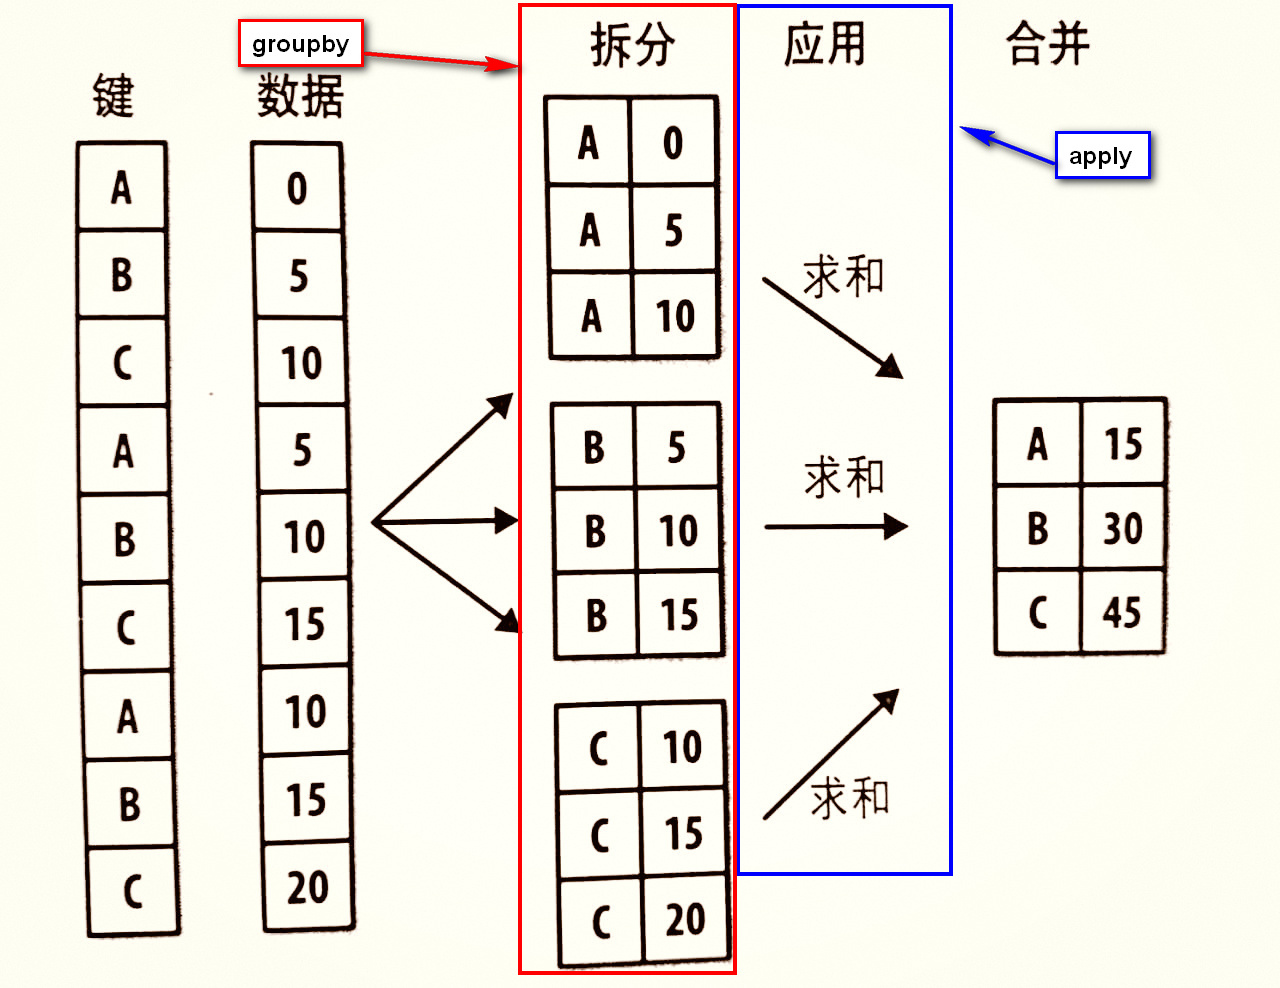

groupby+apply，可以极大的提高我们处理数据的效率，刚开始可能大家用的不熟练，但是等熟悉之后，就会发现它的好处

另外，就是apply的进阶版，agg函数，它是能指定轴上的一个或多个操作进行聚合，同样默认为是列轴。常见用法：`df_columns=df.agg({'col1':[func1,func2],'col2':[func3,func4]})`

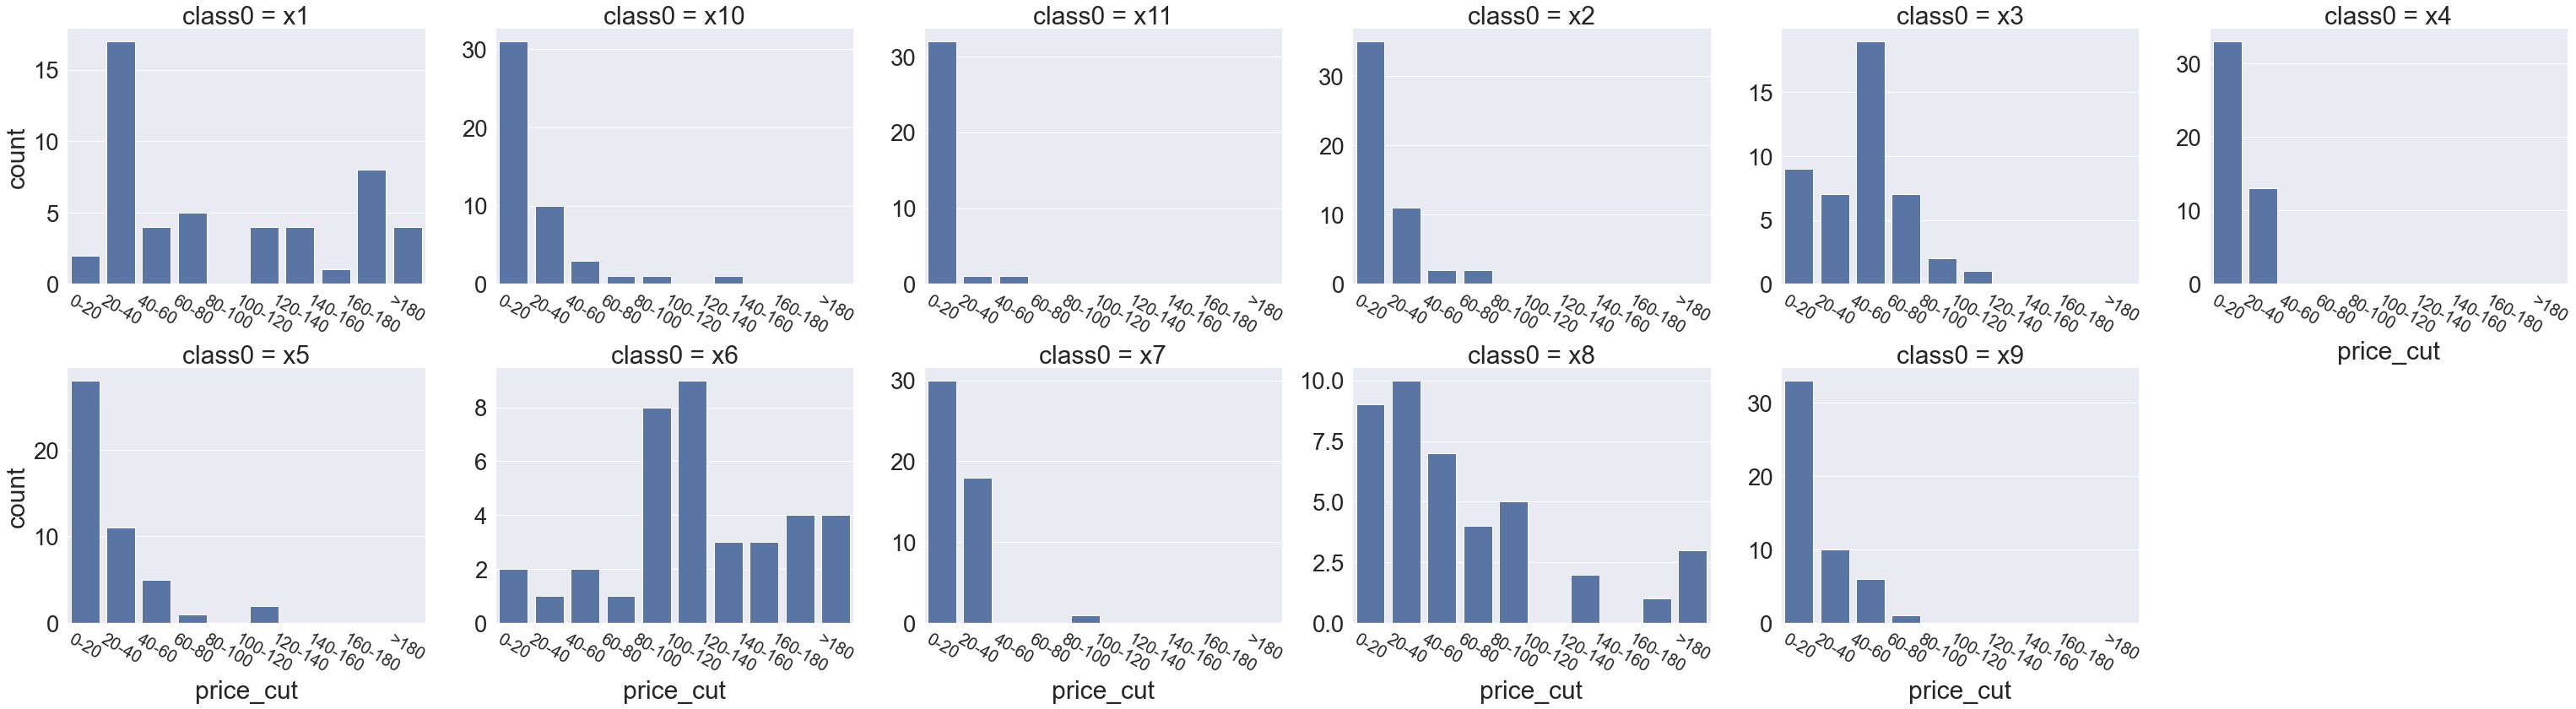

In [48]:
# 统计不同类别下的price_cut频数分布
reviews_class=df_clean.groupby(['class0','price_cut'],as_index=False)['reviews'].agg(['count']).reset_index()
g=sns.FacetGrid(data=reviews_class,col='class0',col_wrap=6,sharex=False,sharey=False,height=6,aspect=1.2)
g.map(sns.barplot,'price_cut','count')
g.set_xticklabels(fontsize=20, rotation=-30)

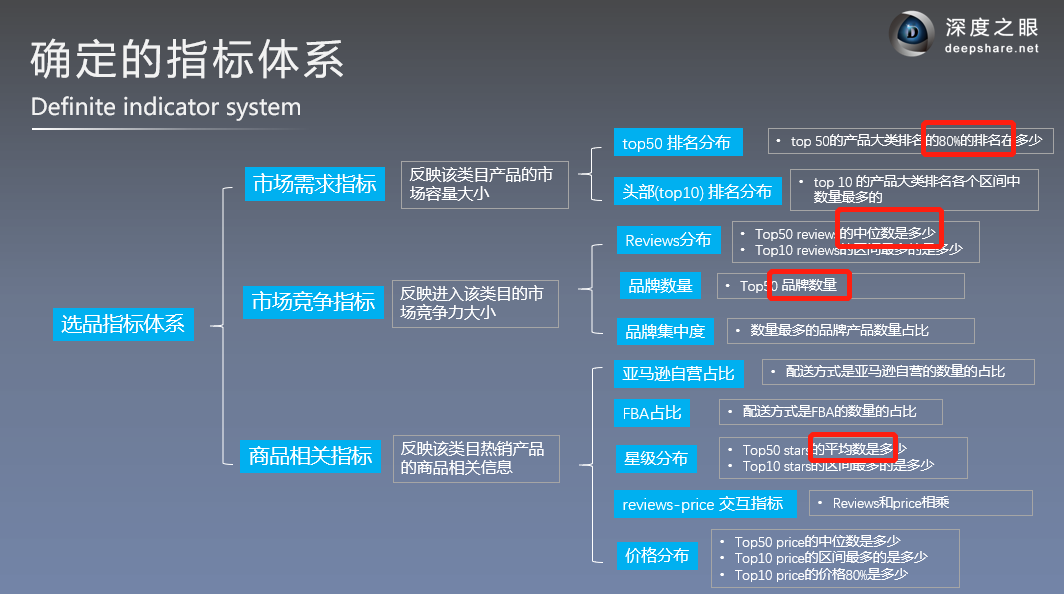

In [49]:
sample=df_clean[df_clean.class0=='x1']
sample

,class0,price,rank1_list,stars,reviews,delivery,rank_big,brand,stock,rank_big_up,...,rank1_list_cut,reviews_cut,price_cut,stars_cut,rank_big_cut,price_cut_n,reviews_cut_n,stars_cut_n,rank_big_cut_n,r_p
0,x1,180.00,1,4.4,6442,Sold by Furbo and Fulfilled by Amazon.,287.0,Furbo,In Stock.,287.0,...,<=10,>2000,>180,4-5,0-500,10,1,5,7,10
1,x1,32.99,2,3.9,1839,Sold by Trekking tribe and Fulfilled by Amazon.,1310.0,TOOGE,In Stock.,1310.0,...,<=10,1500-2000,20-40,3-4,1000-5000,2,2,4,5,4
2,x1,29.99,3,4.2,2032,Sold by FORamerica and Fulfilled by Amazon.,4657.0,BOOCOSA-US,In Stock.,NaN,...,<=10,>2000,20-40,4-5,1000-5000,2,1,5,5,2
3,x1,139.95,4,4.4,376,Sold by Petkey and Fulfilled by Amazon.,8004.0,WOPET,In Stock.,8004.0,...,<=10,300-1000,120-140,4-5,5000-10000,7,4,5,4,28
4,x1,29.99,5,3.8,322,Sold by VI-SON and Fulfilled by Amazon.,9203.0,VINSION,In Stock.,9203.0,...,<=10,300-1000,20-40,3-4,5000-10000,2,4,4,4,8
5,x1,30.99,6,4.2,147,Sold by Trekking tribe and Fulfilled by Amazon.,10510.0,TOOGE,In Stock.,10510.0,...,<=10,100-300,20-40,4-5,10000-50000,2,5,5,3,10
6,x1,34.99,7,4.1,63,Sold by OHOPE and Fulfilled by Amazon.,11764.0,Homenhancing,In Stock.,11764.0,...,<=10,50-100,20-40,4-5,10000-50000,2,6,5,3,12
7,x1,174.29,8,4.4,135,"Sold by Petcube, Inc. and Fulfilled by Amazon.",13541.5,Petcube,In Stock.,NaN,...,<=10,100-300,160-180,4-5,10000-50000,9,5,5,3,45
8,x1,29.99,9,4.4,59,Sold by Uplore and Fulfilled by Amazon.,15319.0,TAOCOCO,In Stock.,15319.0,...,<=10,50-100,20-40,4-5,10000-50000,2,6,5,3,12
9,x1,41.98,10,3.8,19,Sold by Mariotus and Fulfilled by Amazon.,17848.0,DADYPET,In Stock.,17848.0,...,<=10,0-50,40-60,3-4,10000-50000,3,7,4,3,21


- 求集中度，逻辑是频数最高的类别

用到了`Series.value_counts()`函数，其中`ascending=False`是倒序排列，取最大值即类别最高的


In [50]:
n=sample['price_cut']
counts=n.value_counts(ascending=False)
name=n.value_counts(ascending=False).index[0]
num=n.value_counts(ascending=False).values[0]
r=num/sum(counts)

print('数量',counts)
print('name',name)

数量 20-40      17
160-180     8
60-80       5
>180        4
120-140     4
100-120     4
40-60       4
0-20        2
140-160     1
80-100      0
Name: price_cut, dtype: int64
name 20-40


- 求分位数？为什么用分位数而不直接用平均值？

用到了`quantile([0.2,0.4,0.8])`函数，其中列表里是在不同百分比下的变量数值


In [51]:
n=sample['r_p']
n.quantile([0,0.2,0.5,0.8,1])

0.0     2.0
0.2    11.2
0.5    21.0
0.8    45.0
1.0    70.0
Name: r_p, dtype: float64

- 拉平

In [52]:
# 拉平之前
def get_most_count2(n):
    counts=n.value_counts(ascending=False)
    name=n.value_counts(ascending=False).index[0]
    num=n.value_counts(ascending=False).values[0]
    r=num/sum(counts)
    return name,num,r
    
def get_quantile(n):
    return list(n.quantile([0,0.2,0.5,0.8,1]))


feature={
        'price_cut_n':get_most_count2,
        'price':['mean','median','max','min',get_quantile]}
df_clean[['price','stars','reviews']]=df_clean[['price','stars','reviews']].apply(pd.to_numeric)
df_sample=df_clean.groupby('class0').agg(feature)
df_sample.head()

price_cut_n      price                         \
                    get_most_count2       mean median      max    min   
class0                                                                  
x1      (2, 17, 0.3469387755102041)  94.396531  69.87  280.490  18.56   
x10     (1, 31, 0.6595744680851063)  23.848404  16.87  126.965   4.05   
x11     (1, 32, 0.9411764705882353)  10.341765   6.99   45.000   1.17   
x2                     (1, 35, 0.7)  21.202200  16.48   67.990   7.58   
x3      (3, 19, 0.4222222222222222)  44.954222  44.01  111.670   4.79   

                                                           
                                             get_quantile  
class0                                                     
x1                 [18.56, 31.596, 69.87, 170.75, 280.49]  
x10     [4.05, 11.91, 16.87, 33.330000000000005, 126.965]  
x11         [1.17, 5.220000000000001, 6.99, 14.078, 45.0]  
x2                   [7.58, 12.704, 16.48, 26.048, 67.99]  
x3      [4.79, 22.392000000000003, 44.01, 65.302, 111.67]

In [53]:
# 下面这个，是本实操中相对来说最复杂的一段，但是很好理解
def get_info(df): 
    df[['price','stars','reviews']]=df[['price','stars','reviews']].apply(pd.to_numeric)
    
    # 统计各个类别下brand的数量
    b1=df['brand'].value_counts()
    b2=df['brand'].value_counts(normalize=True)   
    
    # 对每一个类别的数值型数据和离散化后的数值型数据进行处理    
    # 统计指标，数值型离散化后的，这个处理方式，是调用的pandas的agg函数
    # 集中度
    def get_most_count2(n):
        counts=n.value_counts(ascending=False)
        name=n.value_counts(ascending=False).index[0]
        num=n.value_counts(ascending=False).values[0]
        r=num/sum(counts)
        return name,num,r
    
    # 分位数
    def get_quantile(n):
        return list(n.quantile([0,0.2,0.5,0.8,1]))

    feature={
            'class0':'count',
            'price_cut_n':get_most_count2,
            'price':['mean','median','max','min',get_quantile],
            'reviews_cut_n':get_most_count2,
            'reviews':['mean','median','max','min',get_quantile],
            'stars_cut_n':get_most_count2,
            'stars':['mean','median','max','min',get_quantile],
            'rank_big_cut_n':get_most_count2,
            'rank_big':['mean','median','max','min',get_quantile]
        }
    
    df_all=df.groupby(['class0']).agg(feature)
    
    # 针对我们更关注的top10
    df_top10=df[df.rank1_list_cut=='<=10'].groupby(['class0']).agg(feature)
    
    # 数据进一步处理，将针对每一个类目的数据拉平成一行
    def get_feature(df,n):
        df_new=df.copy()
        #自定义转换过程
        for col_num, col_name in enumerate(df):
            #拉平，找到相应的列
            if col_name in [('price_cut_n', 'get_most_count2'),('reviews_cut_n', 'get_most_count2'),('stars_cut_n', 'get_most_count2'),('rank_big_cut_n', 'get_most_count2')]:
                # 将这一列的列表、元组分开
                p=df[col_name].apply(pd.Series)
                #print(p)
                # 重命名
                p.columns=[col_name[0]+'_most',col_name[0]+'_most_count',col_name[0]+'_most_ratio']
                # 重新聚合
                df_new=pd.concat([df_new.drop(col_name,axis=1),p],axis=1)
            elif col_name in [('rank_big', 'get_quantile'),('price', 'get_quantile'),('reviews', 'get_quantile'),('stars', 'get_quantile')]:
                p2=df[col_name].apply(pd.Series)
                p2.columns=[col_name[0]+'_0',col_name[0]+'_20',col_name[0]+'_40',col_name[0]+'_80',col_name[0]+'_100']
                df_new=pd.concat([df_new.drop(col_name,axis=1),p2],axis=1)
        name=[]
        for i in df_new.columns:
            if isinstance(i,tuple):
                name.append(i[0]+'-'+i[1])
            else:
                name.append(i)
        df_new.columns=[i+n for i in name]
        return df_new
    
    #合并
    dd=get_feature(df_top10,'_top_10')
    dd1=get_feature(df_all,'_top_50')
    final=pd.concat([dd,dd1],axis=1)
    
    #添加其它的信息进来
    # 某类别下，亚马逊配送数量
    final['amz']=len(df[df.delivery=='Ships from and sold by Amazon.com.'])/len(df)
    final['delivery']=len(df[df['delivery'].str.contains('Fulfilled by Amazon')])/len(df)
    
    #某类别下有多少品牌
    final['brand_count']=len(b1)
    final['brand_top_ratio']=b2[0]
    
    #交互
    final['r_p']=np.mean(df['r_p'])
    #print(final)
    return final

In [54]:
df_clean['class1']=df_clean['class0']
df_featrue=df_clean.groupby(['class1']).apply(get_info).reset_index()
df_featrue.index=df_featrue['class0']

In [55]:
# 主要特征筛选
#选择特征
market_demond_list=['rank_big_cut_n_most_top_10','rank_big_80_top_50']
#市场竞争 
# 选择特征
market_chan_list=['reviews-median_top_50','reviews_cut_n_most_top_10','brand_count','brand_top_ratio']
#商品相关
product_info_list=['amz','delivery','stars_cut_n_most_top_10','stars-mean_top_50','r_p','price-median_top_50','price_cut_n_most_top_10','price_80_top_10']
df_final=df_featrue[market_chan_list+market_demond_list+product_info_list]

In [56]:
df_final

,reviews-median_top_50,reviews_cut_n_most_top_10,brand_count,brand_top_ratio,rank_big_cut_n_most_top_10,rank_big_80_top_50,amz,delivery,stars_cut_n_most_top_10,stars-mean_top_50,r_p,price-median_top_50,price_cut_n_most_top_10,price_80_top_10
class0,,,,,,,,,,,,,,
x1,57.0,6.0,31,0.081633,3.0,82578.1,0.000000,0.897959,5.0,3.993878,27.367347,69.870,2.0,146.818
x10,21.0,6.0,23,0.234043,3.0,69593.0,0.382979,0.382979,5.0,4.212766,10.680851,16.870,1.0,32.670
x11,145.5,5.0,26,0.088235,5.0,47437.4,0.235294,0.735294,5.0,4.170588,5.970588,6.990,1.0,10.138
x2,207.0,4.0,26,0.180000,5.0,12997.8,0.380000,0.620000,5.0,4.118000,7.020000,16.480,1.0,17.374
x3,99.0,4.0,15,0.266667,4.0,82062.2,0.177778,0.488889,5.0,3.893333,15.000000,44.010,3.0,41.790
x4,5.0,7.0,37,0.130435,3.0,150587.0,0.086957,0.652174,5.0,3.241304,8.500000,16.990,1.0,19.894
x5,308.0,1.0,20,0.319149,4.0,14047.4,0.212766,0.787234,5.0,4.410638,6.936170,15.990,1.0,32.990
x6,35.0,5.0,11,0.270270,3.0,157393.8,0.243243,0.108108,5.0,3.472973,39.378378,107.990,6.0,117.438
x7,79.0,4.0,32,0.204082,4.0,26855.2,0.346939,0.591837,5.0,4.677551,8.142857,19.500,2.0,30.202


### 指标体系的进一步处理


In [57]:
data=df_final.copy()

- 指标同向化

In [58]:
#指标同向化，取反
def get_inverse(n):
    return -n

#指标同向化
data[['amz','brand_count','brand_count','reviews-median_top_50','reviews_cut_n_most_top_10']]=data[['amz','brand_count','brand_count','reviews-median_top_50','reviews_cut_n_most_top_10']].apply(get_inverse)

- 数据标准化

这里用到了python的另一个包`sklearn`中的`preprocessing`的预处理数据工具箱，用它我们可以实现数据的标准化，在这里我们用到了`Min-Max`标准化，利用公式 $$ y_i=\frac{x_i-min(x)}{max(x)-min(x)}$$ 

对原始数据的线性变换，使结果落到$ [0,1]$ 区间，可以保留极大极小值。

In [59]:
minmax_scaler = preprocessing.MinMaxScaler()  # 建立MinMaxScaler模型对象
data_scale = minmax_scaler.fit_transform(data)  # MinMaxScaler标准化处理
#构造数据框
data_scale=pd.DataFrame(data_scale,columns=data.columns)
data_scale.index=data.index
data_scale

,reviews-median_top_50,reviews_cut_n_most_top_10,brand_count,brand_top_ratio,rank_big_cut_n_most_top_10,rank_big_80_top_50,amz,delivery,stars_cut_n_most_top_10,stars-mean_top_50,r_p,price-median_top_50,price_cut_n_most_top_10,price_80_top_10
class0,,,,,,,,,,,,,,
x1,0.825658,0.166667,0.230769,0.000000,0.333333,0.210221,1.000000,1.000000,0.0,0.523986,0.640472,0.622574,0.2,1.000000
x10,0.944079,0.166667,0.538462,0.547514,0.333333,0.170989,0.042553,0.348003,0.0,0.676389,0.140993,0.097822,0.0,0.164852
x11,0.534539,0.333333,0.423077,0.023719,1.000000,0.104051,0.411765,0.794056,0.0,0.647022,0.000000,0.000000,0.0,0.000000
x2,0.332237,0.500000,0.423077,0.353372,1.000000,0.000000,0.050000,0.648087,0.0,0.610407,0.031412,0.093960,0.0,0.052941
x3,0.687500,0.500000,0.846154,0.664712,0.666667,0.208662,0.555556,0.482092,0.0,0.453981,0.270279,0.366535,0.4,0.231577
x4,0.996711,0.000000,0.000000,0.175316,0.333333,0.415693,0.782609,0.688821,0.0,0.000000,0.075713,0.099010,0.0,0.071378
x5,0.000000,1.000000,0.653846,0.853248,0.666667,0.003171,0.468085,0.859815,0.0,0.814160,0.028903,0.089109,0.0,0.167193
x6,0.898026,0.333333,1.000000,0.677657,0.333333,0.436259,0.391892,0.000000,0.0,0.161301,1.000000,1.000000,1.0,0.785045
x7,0.753289,0.500000,0.192308,0.439883,0.666667,0.041867,0.132653,0.612430,0.0,1.000000,0.065023,0.123861,0.2,0.146795


### 指标权重确定

- 主观评价法

In [60]:
#方法一 手动赋权，目的是更个性化，更可以解释
market_demond=0.3
market_chan=0.4
product_info=0.3
weight_dict={
        #市场需求:权重和为1
        'rank_big_cut_n_most_top_10':market_demond*0.6,
        'rank_big_80_top_50':market_demond*0.4,
        
        #市场竞争:权重和为1
        'reviews-median_top_50':market_chan*0.2,
        'reviews_cut_n_most_top_10':market_chan*0.3,
        'brand_count':market_chan*0.3,
        'brand_top_ratio':market_chan*0.2,
        
        #商品相关:权重和为1
        'amz':product_info*0.2,
        'delivery':product_info*0.05,
        'stars_cut_n_most_top_10':product_info*0.05,
        'stars-mean_top_50':product_info*0.05,
        'r_p':product_info*0.3,
        'price-median_top_50':market_demond*0.05,
        'price_cut_n_most_top_10':market_demond*0.2,
        'price_80_top_10':market_demond*0.1
        }
#专家赋权
W1 = pd.DataFrame(weight_dict,index=['expert_w']).T

- 熵权法（了解）

第一步： k个指标 $ X_1,X_2,\ldots ,X_k $，其中$ X_i={x_1,x_2,\ldots,x_n} $，其中，$Xi$均是标准化后的值。

第二步：求各指标的信息熵，一组数据的信息熵$E_j=-ln(n)^{-1} \sum_{i=1}^np_{ij}lnp_{ij} $。其中 $p_{ij}=\frac{Y_{ij}}{\sum_{j=1}^nY_{ij}}$

第三步，确定权重：根据信息熵的计算公式，计算出各个指标的信息熵为$E_1,E_2,\ldots,E_k$，通过信息熵计算各个指标权重为$W_i=\frac{1-E_i}{k-\sum E_i} (i=1,2,\ldots,k)$


In [61]:
def entropy(df1):
    df=df1.copy()
    n=list(df.columns)
    #建立数据比重矩阵 p
    for i in n:
        # 计算指标总和
        Sum = np.sum(df[i])      
        # 计算各数据某一指标占比
        df[i] = df[i]/Sum
    #计算指标信息熵和信息效用值d
    m=len(df)
    E = []
    # 计算信息熵值
    for i in n: #针对每一列来看
        K = 1/np.log(m)
        e = - K * np.sum(df[i] * np.log(df[i]))
        E.append(e)    
    # 转换为数组形式
    E = np.array(E) 
    # 计算效用价值
    D = 1 - E
    #计算指标权重
    W = D/np.sum(D)
    # 转换形式
    W = np.array([W])    
    # 保存 权重 为excel格式
    W1 = pd.DataFrame(W.T, index = n)    
    W1.columns=['entropy_w']
    return W1
#熵权法
W2=entropy(data_scale)

In [62]:
W_final=W1.join(W2)
W_final

,expert_w,entropy_w
rank_big_cut_n_most_top_10,0.180,0.025240
rank_big_80_top_50,0.120,0.081813
reviews-median_top_50,0.080,0.021176
reviews_cut_n_most_top_10,0.120,0.043557
brand_count,0.120,0.025664
brand_top_ratio,0.080,0.039187
amz,0.060,0.046476
delivery,0.015,0.021723
stars_cut_n_most_top_10,0.015,0.314013
stars-mean_top_50,0.015,0.024986


## 第五步 综合指标法
将分数与权重相乘得到最终综合得分

In [63]:
def get_score(df,name,weight='entropy_w',col='final_score'):
    '''
    df:数据框
    name:指标列表
    weight:权重选择
    col:指标列表名字
    '''
    # name是一级分类，也可以是所有的
    t1=df[name]
    #用到的权重体系
    W=W_final.loc[name,weight]
    W=np.array(W)
    #计算并保存分数
    U=[]
    for i in range(1,len(t1)+1):
        # 获取样本各个指标的值
        y=t1[i-1:i].values
        # 综合得分
        u=np.sum(y*W)*100
        U.append(u)
    U=pd.DataFrame(U,index=list(t1.index))
    U.columns=[col]
    U[col+' rank']=U[col].rank(ascending=False)
    return U

In [64]:
data_final=get_score(data_scale,market_demond_list,'expert_w','score_market_demond')
data_final=data_final.join(get_score(data_scale,market_chan_list,'expert_w','score_market_chan'))
data_final=data_final.join(get_score(data_scale,product_info_list,'expert_w','score_product_info'))
data_final['score']=data_final['score_market_demond']+data_final['score_market_chan']+data_final['score_product_info']
#排名，取高的
data_final['rank']=data_final['score'].rank(ascending=False)

data_final.sort_values('rank')

,score_market_demond,score_market_demond rank,score_market_chan,score_market_chan rank,score_product_info,score_product_info rank,score,rank
x6,11.235103,8.0,28.605468,1.0,21.448440,1.0,61.289010,1.0
x3,14.503942,4.0,26.971539,2.0,10.814485,4.0,52.289966,2.0
x9,18.150967,2.0,25.533401,4.0,2.193608,11.0,45.877975,3.0
x5,12.038053,6.0,26.672135,3.0,6.214843,6.0,44.925031,4.0
x8,12.000000,7.0,16.782744,7.0,14.323401,3.0,43.106144,5.0
x1,8.522646,10.0,11.374494,10.0,19.184090,2.0,39.081230,6.0
x11,19.248614,1.0,13.542992,9.0,4.632206,8.0,37.423812,7.0
x2,18.000000,3.0,16.561797,8.0,2.770215,10.0,37.332012,8.0
x7,12.502403,5.0,17.853070,6.0,5.625947,7.0,35.981420,9.0
x10,8.051869,11.0,20.394279,5.0,3.702133,9.0,32.148281,10.0


In [65]:
data_final_2=get_score(data_scale,market_chan_list+market_demond_list+product_info_list,'entropy_w','score_en')
data_final_2.sort_values('score_en rank')

,score_en,score_en rank
x6,49.313248,1.0
x1,33.305273,2.0
x8,33.264654,3.0
x3,28.240713,4.0
x5,19.202521,5.0
x7,17.490191,6.0
x9,15.048408,7.0
x10,14.217486,8.0
x4,14.022255,9.0
x11,12.393093,10.0


## 最终反馈信息

In [66]:
#主观评价法确定范围:选top3
data_final[data_final['rank']<=3].index #选x1 x6 x7三个类目
data_final[data_final['score']>=40].index #选x1 x6 x7两个类目

Index(['x3', 'x5', 'x6', 'x8', 'x9'], dtype='object')

In [67]:
#客观评价法
data_final_2[data_final_2['score_en rank']<=3].index #同样选x1 x6 x8三个类目
data_final_2[data_final_2['score_en']>=30].index #选x1 x6三个类目


Index(['x1', 'x6', 'x8'], dtype='object')